In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand
from pyspark.sql.functions import rand
from pyspark.sql.types import IntegerType, StructType, StructField, FloatType, StringType
import math
import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn

seaborn.set_style("ticks")

In [2]:
schema = StructType([
    StructField("incident_num", StringType(), True), \
    StructField("offence_code", IntegerType(), True), \
    StructField("offence_code_group", StringType(), True), \
    StructField("offence_description", StringType(), True), \
    StructField("district",  StringType(), True), \
    StructField("reporting_area",  IntegerType(), True), \
    StructField("shooting",  IntegerType(), True), \
    StructField("occurrancy_on_data", StringType(), True), \
    StructField("year",  IntegerType(), True), \
    StructField("month",  IntegerType(), True), \
    StructField("day_of_week", StringType(), True), \
    StructField("hour", IntegerType(), True), \
    StructField("UCR_part", StringType(), True), \
    StructField("street", StringType(), True), \
    StructField("lat", FloatType(), True), \
    StructField("long", FloatType(), True), \
    StructField("location", StringType(), True)
])


In [3]:
reader = SparkSession.builder.appName("weather").config("spark.some.config.option", "some-value").getOrCreate()

In [4]:
# read data

In [5]:
data = reader.read.csv("hdfs://namenode/crime_Boston.csv", header = True, schema = schema)

In [6]:
# create tables
data.createOrReplaceTempView("data")

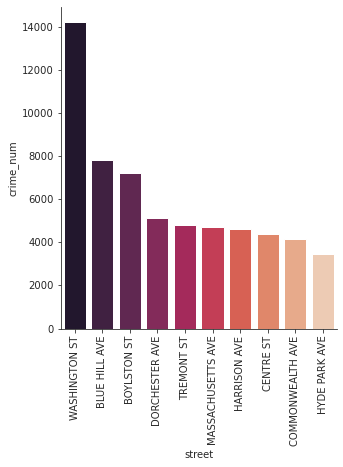

In [7]:
# retrive data
crime_num_per_street = reader.sql("  \
    select \
    count(offence_code) as crime_num, street \
    from \
    data \
    where \
    street \
    is not null \
    group by \
    street \
    order by \
    crime_num DESC limit 10")
crime_num_per_street.createOrReplaceTempView("crime_num_per_street")

crime_num_per_street = crime_num_per_street.toPandas()
crime_street_chart = seaborn.catplot(x ='street', y='crime_num', kind="bar",palette="rocket", data=crime_num_per_street)
crime_street_chart.set_xticklabels(rotation=90)



<AxesSubplot:title={'center':'percentage of top 15 offence group'}, ylabel='crime_num'>

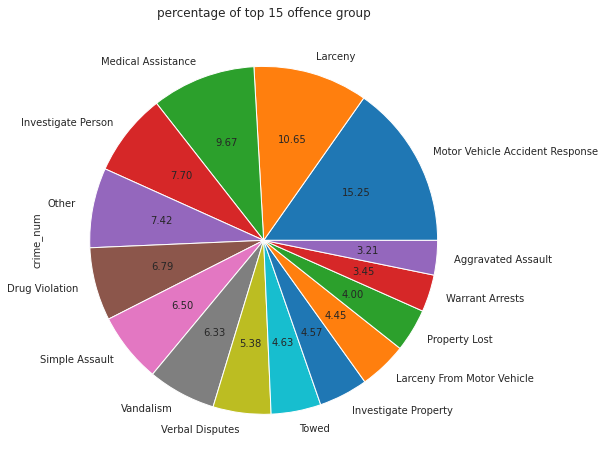

In [8]:
offence_num_each_group = reader.sql(" \
    select \
    count(offence_code) as crime_num, offence_code_group \
    from \
    data \
    group by \
    offence_code_group \
    order by \
    crime_num DESC limit 15 \
  ")

# print(offence_num_each_group.show())

offence_num_group_chart = offence_num_each_group.toPandas()
offence_num_group_chart.plot(kind='pie', y='crime_num', labels=offence_num_group_chart['offence_code_group'],autopct='%.2f', legend=False, figsize=(8,8), title="percentage of top 15 offence group")


In [9]:
crime_2016 = reader.sql("select \
      count(offence_code) as crime_num_2016, month \
      from \
      data \
      where year = 2016 \
      and \
      month between 1 and 8 \
      group by \
      month \
      order by \
      month ASC")
crime_2017 = reader.sql("select \
      count(offence_code) as crime_num_2017, month \
      from \
      data \
      where year = 2017 \
      and \
      month between 1 and 8 \
      group by \
      month \
      order by \
      month ASC")
crime_2018 = reader.sql("select \
      count(offence_code) as crime_num_2018, month \
      from \
      data \
      where year = 2018 \
      and \
      month between 1 and 8 \
      group by \
      month \
      order by \
      month ASC")
crime_2016.createOrReplaceTempView("crime_2016")
crime_2017.createOrReplaceTempView("crime_2017")
crime_2018.createOrReplaceTempView("crime_2018")
crime_per_year = reader.sql(" \
    select \
    I.crime_num_2016, I.crime_num_2017, E.crime_num_2018, E.month \
    from \
    crime_2018 as E \
    inner join \
    (select \
        S.crime_num_2017, X.crime_num_2016, X.month from \
        crime_2017 as S \
        inner join \
        crime_2016  as X \
        on \
        S.month = X.month \
        ) as I \
    on \
    E.month = I.month \
    order by \
    E.month ASC \
    ")

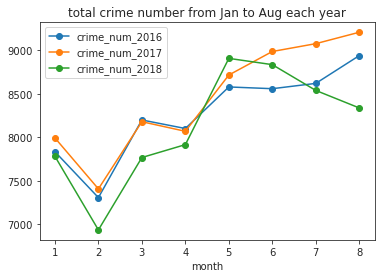

In [10]:
crime_per_year = crime_per_year.toPandas()
crime_pear_year_chart = crime_per_year.plot(kind='line', x='month', y = ["crime_num_2016","crime_num_2017","crime_num_2018"], marker="o", title="total crime number from Jan to Aug each year")

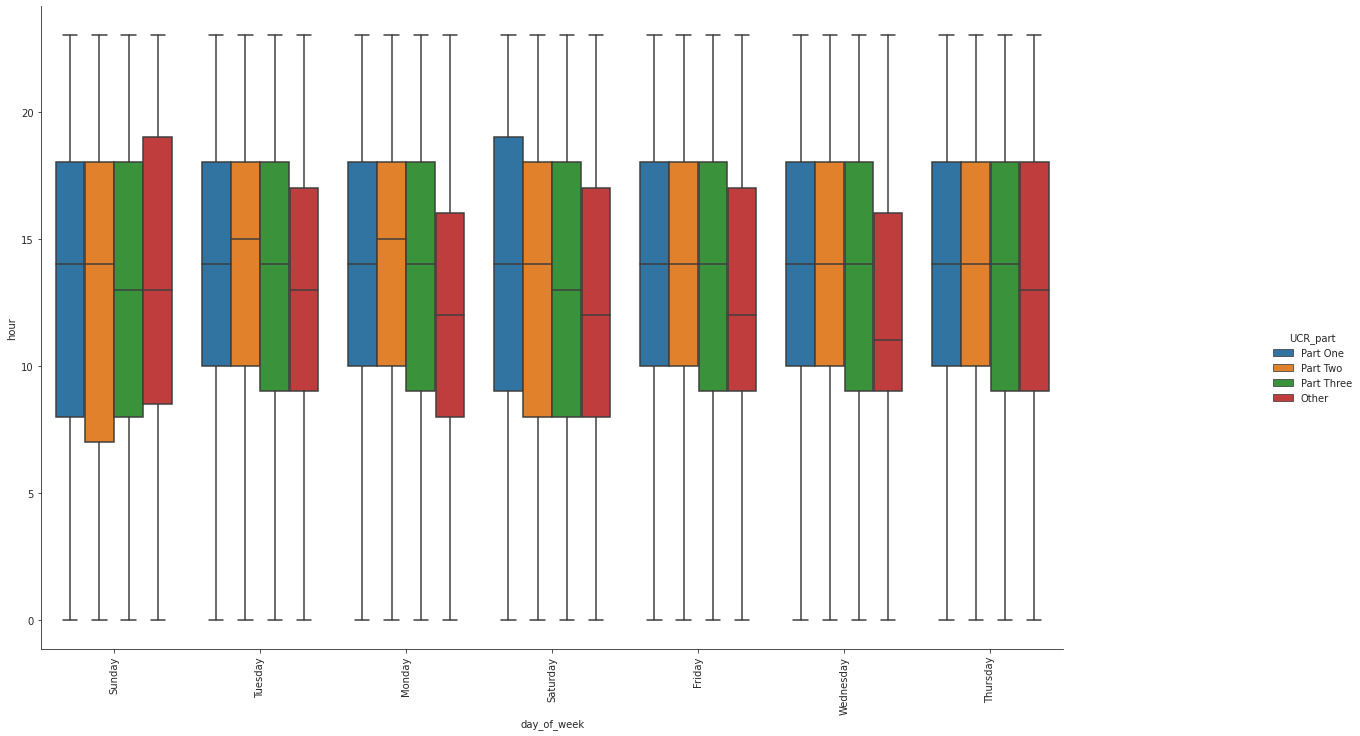

In [11]:
crime_time_per_group = reader.sql(" \
    select \
    hour, day_of_week, UCR_part \
    from \
    data \
")
crime_time_per_group = crime_time_per_group.toPandas()
crime_time_chart = seaborn.catplot(x = 'day_of_week', y='hour', hue='UCR_part', kind='box', data=crime_time_per_group)
crime_time_chart.set_xticklabels(rotation=90)
crime_time_chart.fig.set_size_inches(20,10)

In [12]:
crime_street_top = reader.sql("  \
    select street from \
    (select \
    count(offence_code) as crime_num, street \
    from \
    data \
    where \
    street \
    is not null \
    group by \
    street \
    order by \
    crime_num DESC limit 10) \
    where crime_num >= 5000 \
    ")
crime_street_top.createOrReplaceTempView("crime_street_top")

offence_group_top = reader.sql(" \
    select \
    count(offence_code) as crime_num, offence_code_group \
    from \
    data \
    group by \
    offence_code_group \
    order by \
    crime_num DESC limit 5 \
  ")
offence_group_top.createOrReplaceTempView("offence_group_top")
                      

In [13]:
union_data_cops = reader.sql(" \
    select \
    hour, day_of_week, street, offence_code_group \
    from \
    data \
    where \
    street in (select street from crime_street_top) \
    and \
    offence_code_group in (select offence_code_group from offence_group_top) \
")
# print(union_data_cops.show())
union_data_cops = union_data_cops.toPandas()

/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


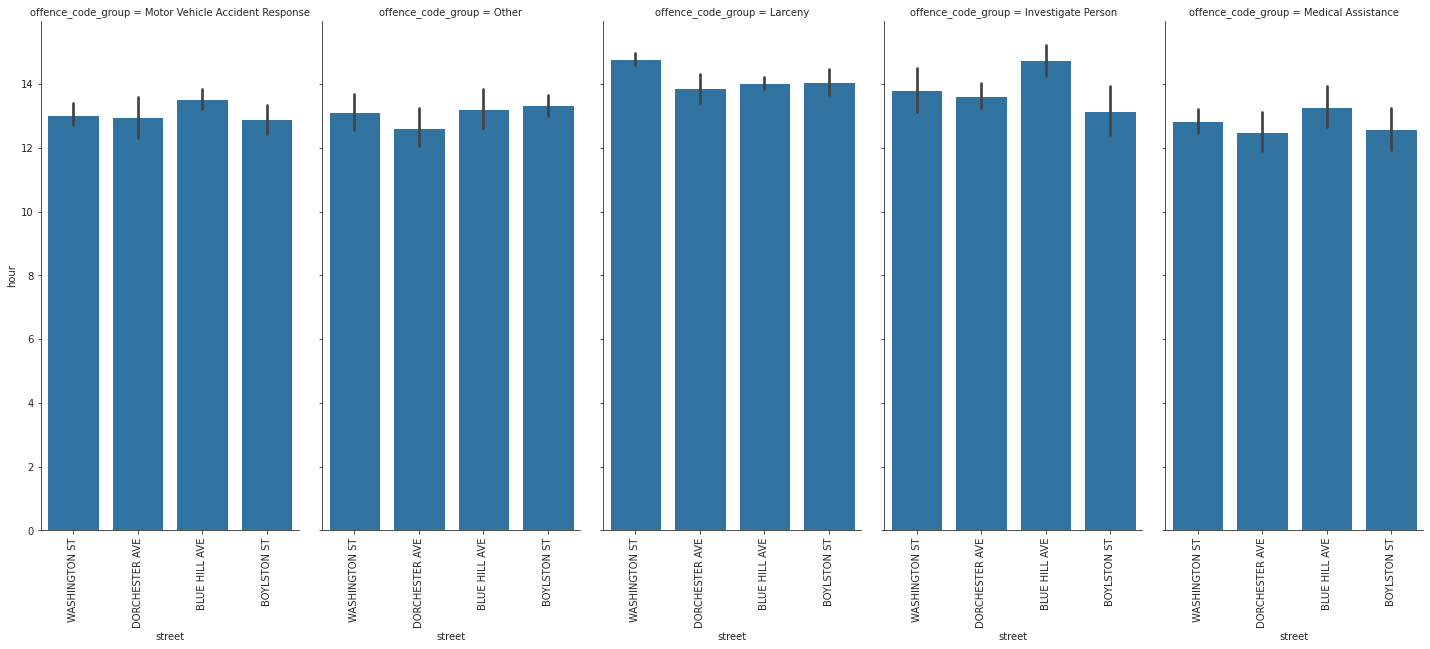

In [14]:

union_data_cops_analysis = seaborn.FacetGrid(union_data_cops, col='offence_code_group', height=8, aspect=0.5)
union_data_cops_analysis.map(seaborn.barplot, "street", "hour")
union_data_cops_analysis.set_xticklabels(rotation=90)

In [15]:
offences_by_level = reader.sql(" \
    select \
    distinct(offence_code_group), UCR_part \
    from \
    data \
")

offences_by_level.createOrReplaceTempView("offences_by_level")



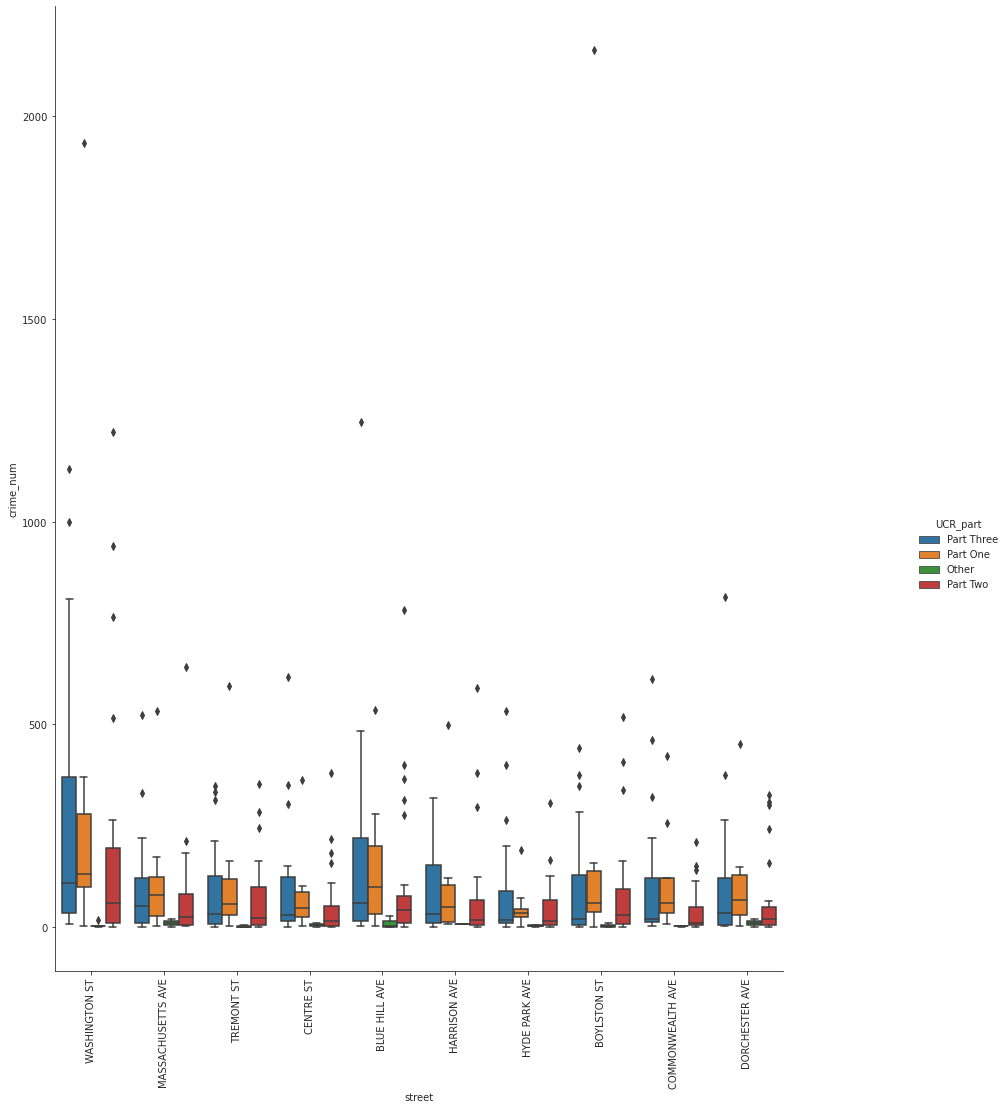

In [16]:
street_dangerous = reader.sql(" \
    select \
    count(offence_code_group) as crime_num, offence_code_group, street, UCR_part \
    from \
    data \
    where \
    street in(select street from crime_num_per_street) \
    group by \
    offence_code_group, street, UCR_part \
")
# print(street_dangerous.show())
street_dangerous = street_dangerous.toPandas()
street_dangerous_chart = seaborn.catplot(x = 'street', y='crime_num', hue='UCR_part', kind='box', data=street_dangerous)
street_dangerous_chart.set_xticklabels(rotation=90)
street_dangerous_chart.fig.set_size_inches(15,15)

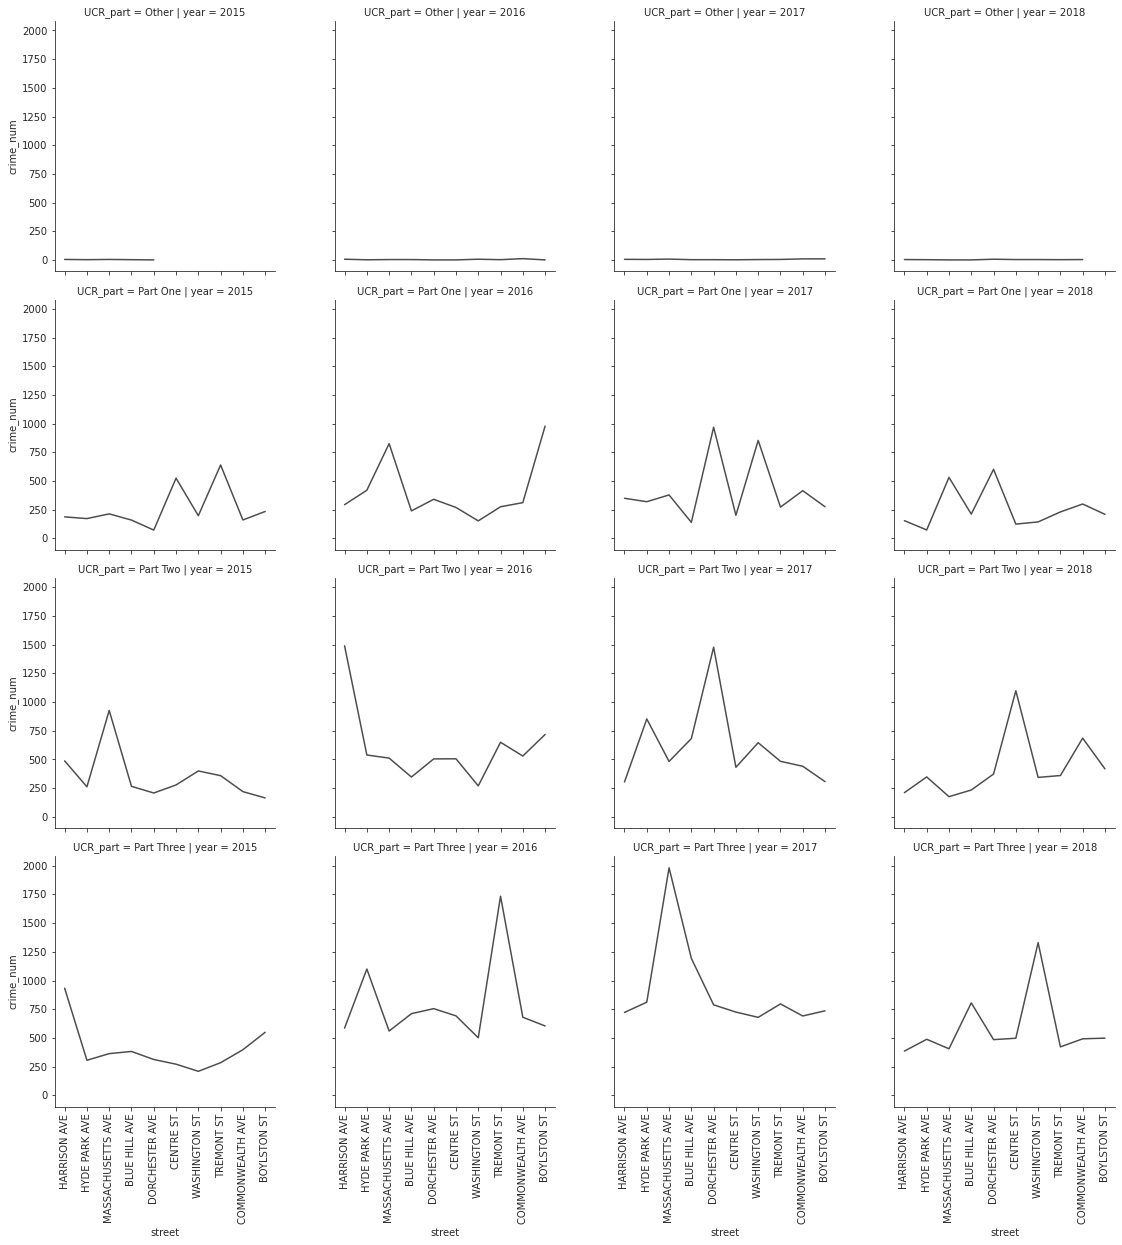

In [17]:
year_dangerous = reader.sql(" \
    select \
    count(offence_code_group) as crime_num, street, UCR_part, year \
    from \
    data \
    where \
    street in(select street from crime_num_per_street) \
    group by \
    street, UCR_part, year \
")

year_dangerous = year_dangerous.toPandas()
year_dangerous_chart =seaborn.FacetGrid(year_dangerous,row="UCR_part", col="year", height=4)
year_dangerous_chart.map(seaborn.lineplot, "street", "crime_num", color=".3")
year_dangerous_chart.set_xticklabels(rotation=90)